In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image

## Load data

In [18]:
masks = glob.glob("../input/isbi2015/train/label/*.png")
orgs = glob.glob("../input/isbi2015/train/image/*.png")

In [19]:
imgs_list = []
masks_list = []
for image, mask in zip(orgs, masks):
    imgs_list.append(np.array(Image.open(image).resize((512,512))))
    
    im = Image.open(mask).resize((512,512))
    #width, height = im.size   # Get dimensions

    #left = (width - 388)/2
    #top = (height - 388)/2
    #right = (width + 388)/2
    #bottom = (height + 388)/2

    #im_cropped = im.crop((left, top, right, bottom))
    masks_list.append(np.array(im))

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

In [20]:
print(imgs_np.shape, masks_np.shape)

(30, 512, 512) (30, 512, 512)


## Plot images + masks + overlay (mask over original)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

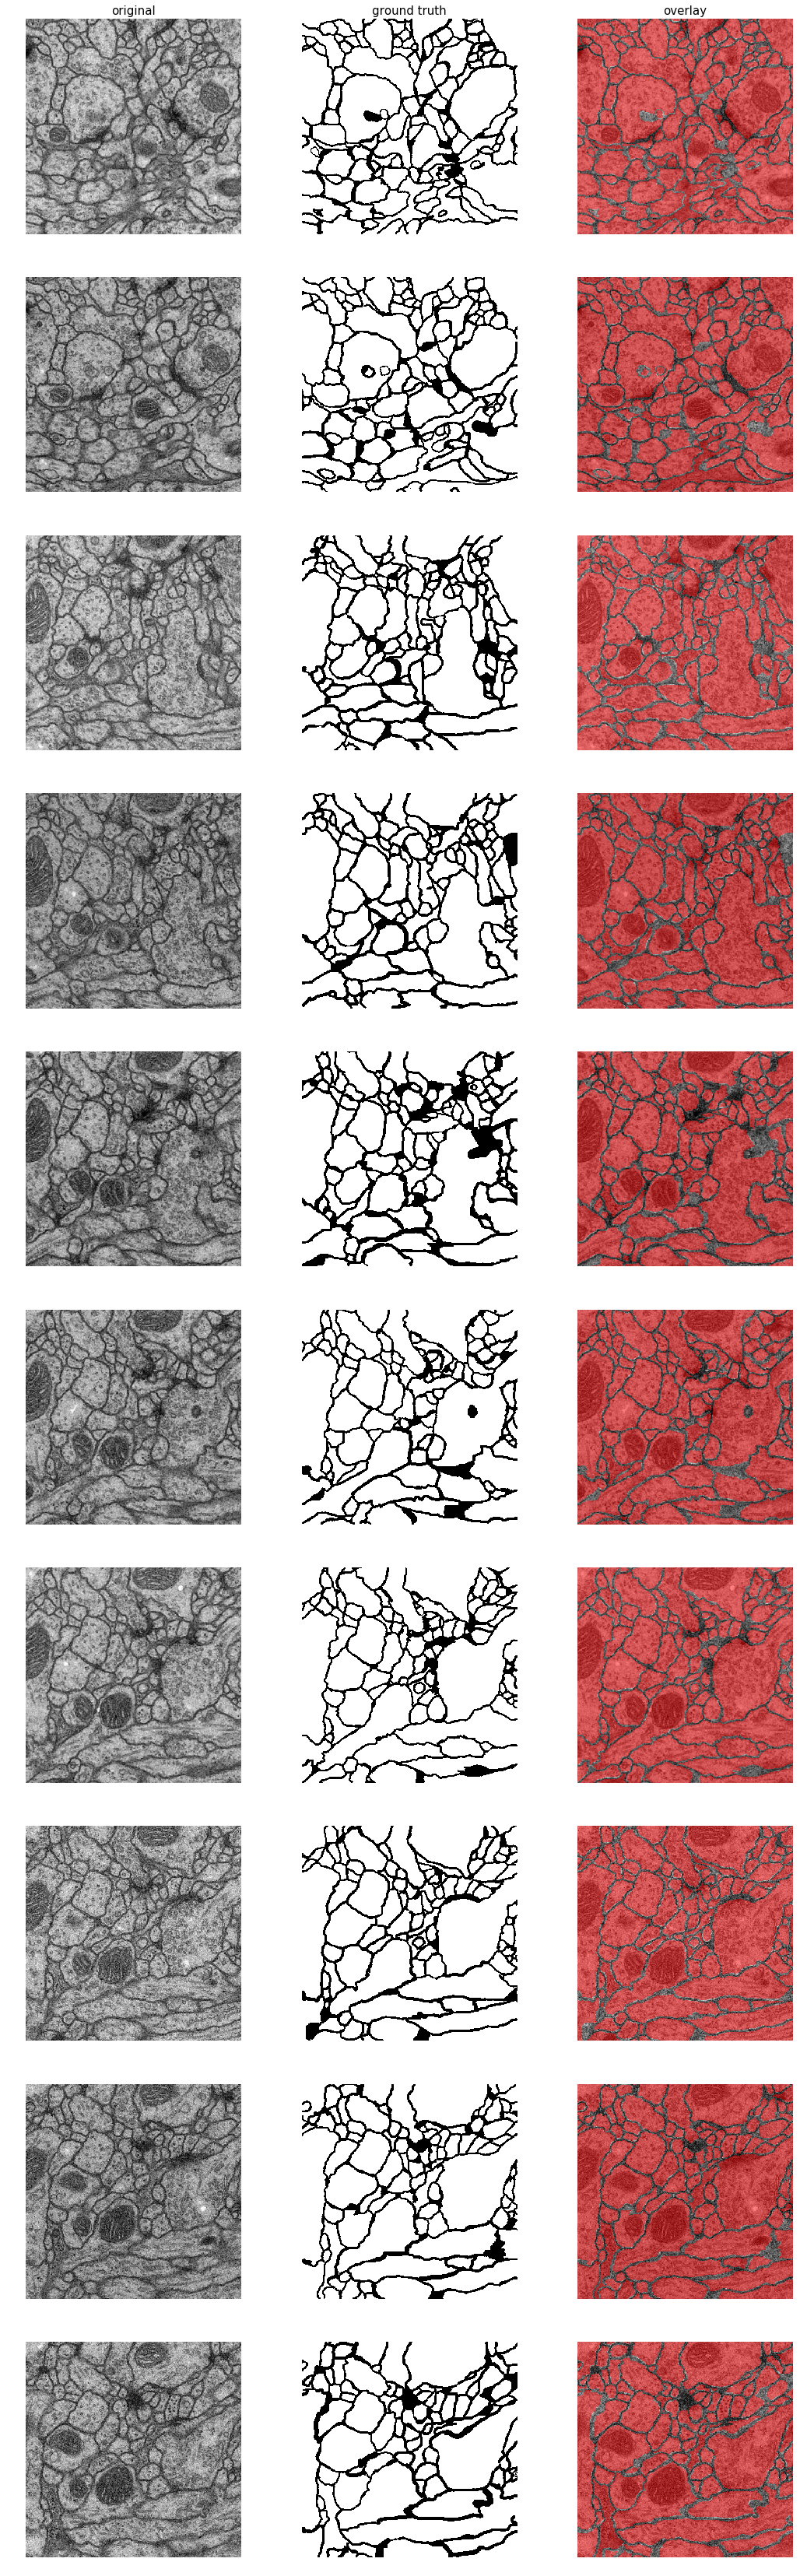

In [21]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=10, figsize=6)


## Get data into correct shape, dtype and range (0.0-1.0)

In [22]:
print(imgs_np.max(), masks_np.max())

255 255


In [23]:
x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)/255

In [24]:
print(x.max(), y.max())

1.0 1.0


In [25]:
print(x.shape, y.shape)

(30, 512, 512) (30, 512, 512)


In [26]:
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
print(x.shape, y.shape)

(30, 512, 512) (30, 512, 512, 1)


In [27]:
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
print(x.shape, y.shape)

(30, 512, 512, 1) (30, 512, 512, 1)


##  Train/val split

In [28]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (15, 512, 512, 1)
y_train:  (15, 512, 512, 1)
x_val:  (15, 512, 512, 1)
y_val:  (15, 512, 512, 1)


## Prepare train generator with data augmentation

In [29]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 512, 512, 1) (2, 512, 512, 1)


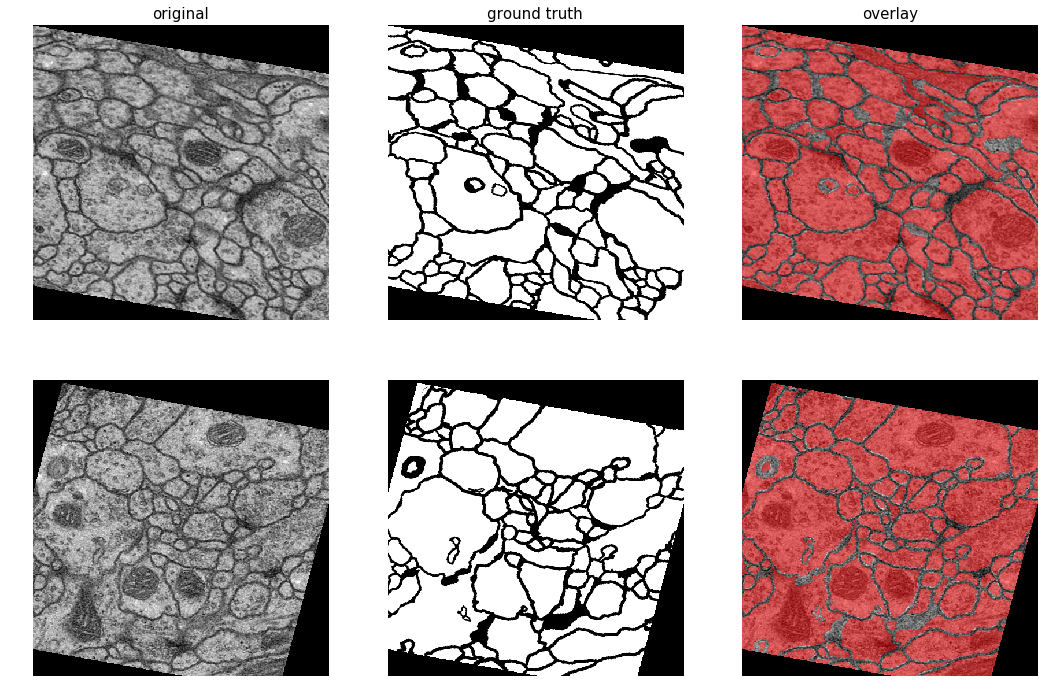

In [30]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

## Initialize network

In [31]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [32]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 512, 512, 64) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 512, 512, 64) 36928       dropout_6[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [33]:
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files (x86)\\Graphviz2.38\\bin\\"

In [ ]:
import sys
print(sys.path)

sys.path.append("C:\\Program Files (x86)\\Graphviz2.38\\bin\\") 

print(sys.path)

In [17]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

## Compile + train

In [34]:
from keras.callbacks import ModelCheckpoint


model_filename = 'segm_model_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [35]:
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    #optimizer=Adam(), 
    optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)


In [ ]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=10,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

Epoch 1/10


## Plot training history

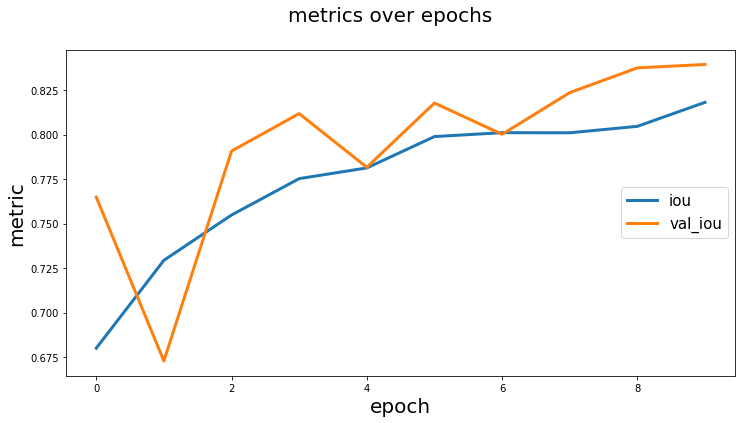

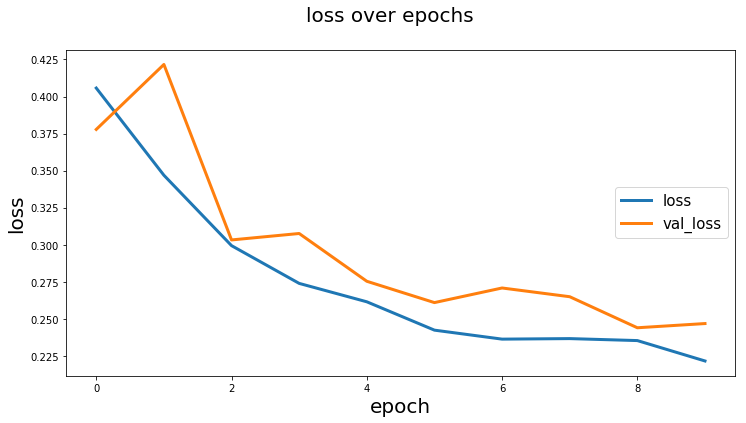

In [45]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

## Plot original + ground truth + pred + overlay (pred on top of original)

In [17]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)

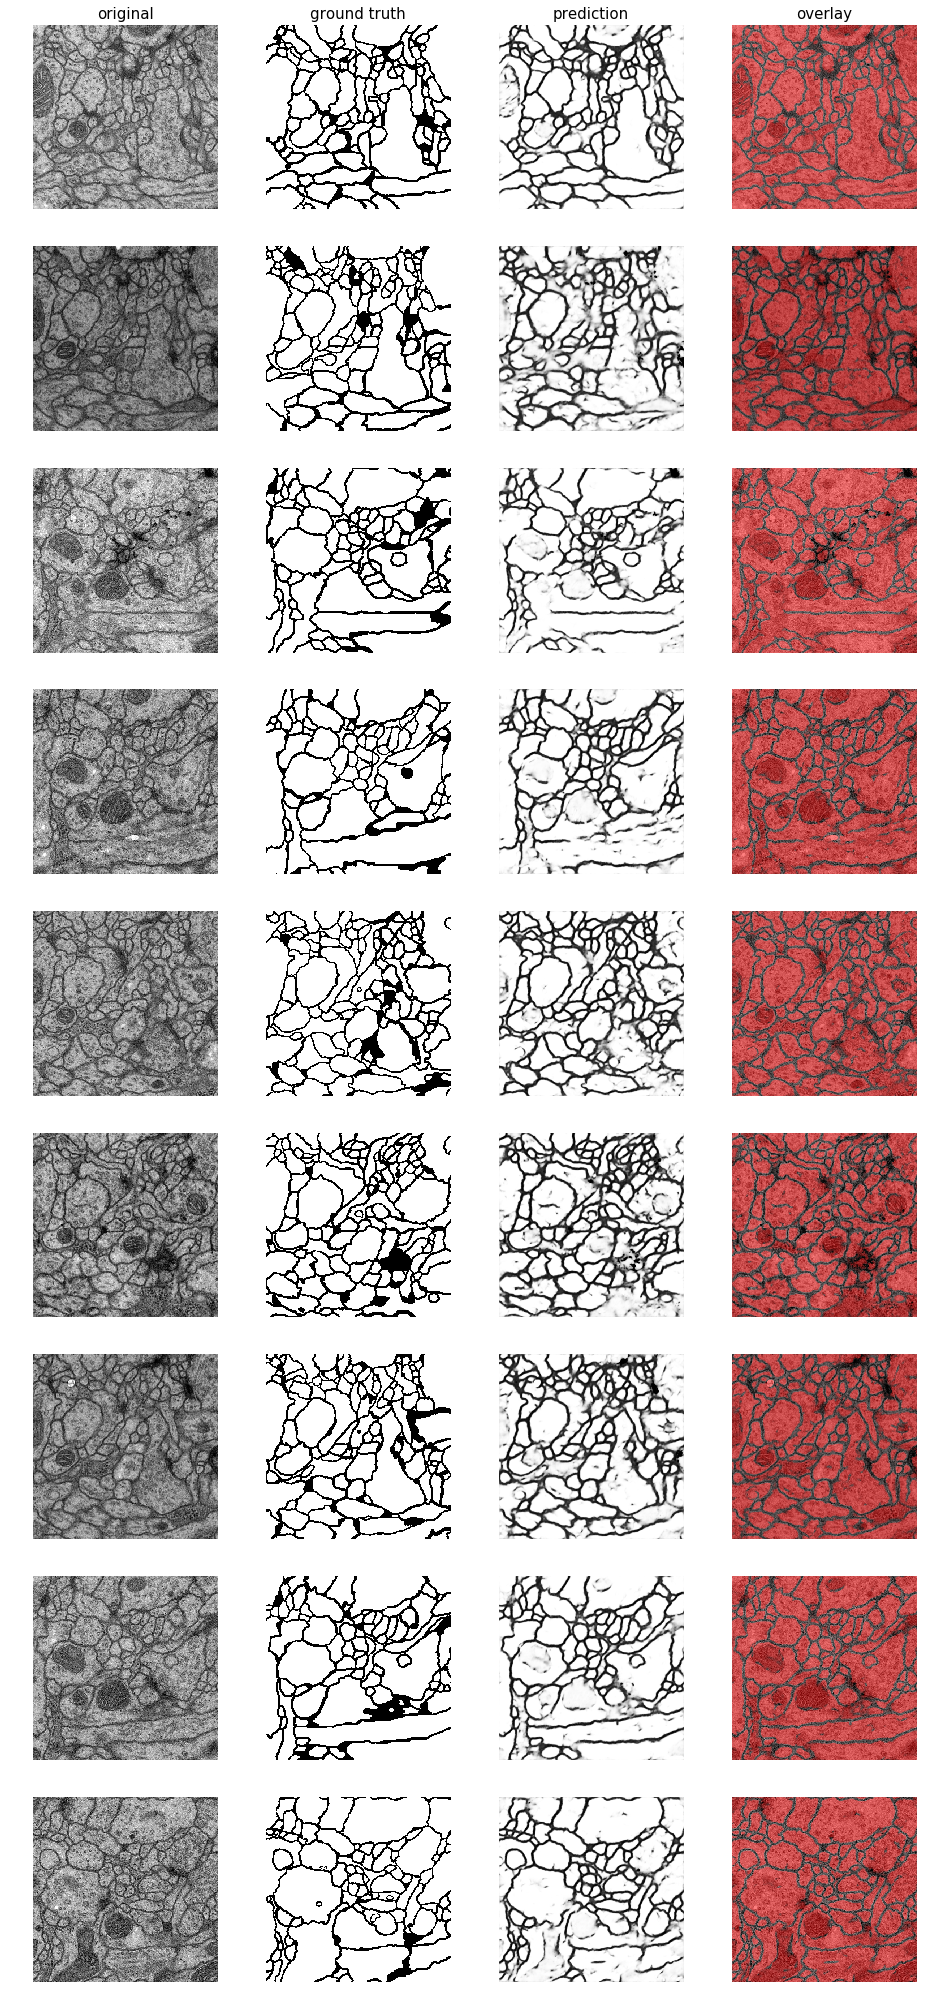

In [18]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=9)